In [1]:
# Note: Run this code only the first time you run the script
# Install packages. 

#using Pkg
#Pkg.add("Distributions")
#Pkg.add("Random")
#Pkg.add("Plots")
#Pkg.add("QuadGK")
#Pkg.add("SparseArrays")
#Pkg.add("LinearAlgebra")
#Pkg.add("NLsolve")
#Pkg.add("Roots")
#Pkg.add("LaTeXStrings")

# Numerically solving McCall models

In this note we are going to show how to solve numerically versions of the McCall model using Julia. Notation follows the notation in the lectures.

In [1]:
# Load packages
using Distributions
using Random
using Plots
using QuadGK
using SparseArrays
using LinearAlgebra
using NLsolve
using Roots
using LaTeXStrings

## Basic McCall model

First, consider the basic McCall model (without separations) in discrete time. 

The Bellman equations for the model are

$$W(w)=w+\frac{1}{1+r}W(w)$$
$$U = z + \frac{1}{1+r}\left[(1-\alpha)U + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W(w'),U\}f(w')dw'\right]$$

where $f(.)$ is the pdf of the wage offer distribution, and $\underline{w}$ and $\bar{w}$ denote the (exogenous) bounds of the support of the offer distribution (the minimum and maximum offerred wages). 

Recall that optimal behaviour is fully characterized by a unique reservation wage, $w_R$, defined implicitly as the solution to 

$$w_R=z+\frac{\alpha}{r}\int_{\underline{w_R}}^{\bar{w}}(w'-w_R)f(w')dw'$$

In what follows we will explore different ways to solve the model numerically. Note that for a model to be solved numerically, we need to assign specific values to all parameters and functional forms. 

In these examples, let's set the parameters to $r=0.04$, $\alpha = 0.3$, $z=0.2$. 


In [3]:
# Set parameters
r=0.04;
alpha=0.3;
z=0.2;

For the first set of examples, let's choose a particularly simple form for the offer distribution, namely uniform distribution from 0 to 1, i.e. 

$$f(w)=\left\{\begin{array}{lcr}1&\text{ if }&w\in[0,1]\\0&\text{ if }&w\notin[0,1]\end{array}\right.$$

As we will see later, it is easy to set more realitic distributions for numerical solutions, however, with uniform distribution we can obtain an analytical expression for the reservation wage equation and therefore compare the (approximate) solutions from numerical methods to the exact solution.

In [4]:
# Set the wage offer distribution
wmin=0;
wmax=1;
f(w)=pdf.(Uniform(wmin,wmax),w)

f (generic function with 1 method)

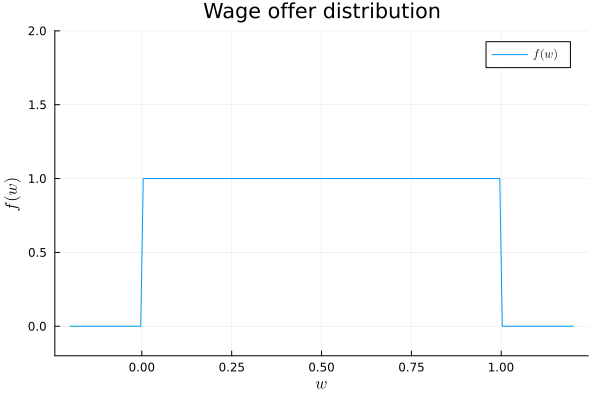

In [5]:
# Wage offer grid and plot of pdf
ws = collect(range(-0.2,stop=1.2,length=200))
plot(ws,f(ws),label=L"f(w)",ylim=[-0.2,2],title="Wage offer distribution",xlabel=L"w", ylabel=L"f(w)")

### Using closed-form solution

In the special case of uniform distribution the reservation wage equation has a closed form solution. Note that the reservation wage equation is now

$$w_R=z+\frac{\alpha}{r}\int_{0}^{1}(w'-w_R)dw'$$

Integrating directly 

$$w_R=z+\frac{\alpha}{r}\left[\int_{0}^{1}w'dw'-\int_{0}^{1}w_Rdw'\right] = z + \frac{\alpha}{2r}-\frac{\alpha}{r}w_R+\frac{\alpha}{2r}w_R^2$$

Hence the reservation wage solves the quadratic equation

$$0 = \frac{\alpha}{2r}w_R^2-\frac{r+\alpha}{r}w_R+(z+\frac{\alpha}{2r})$$

which has only one solution in $[0,1]$, namely 

$$w_R=\frac{r+\alpha-\sqrt{r^2+2r\alpha-2r\alpha z}}{\alpha}$$

This is the exact solution of the model. 

Note that under the parameters set this evaluates to 0.6526

In [6]:
# Exact solution for the reservation wage

wr_analytical = (r+alpha - sqrt(r^2+2*r*alpha-2*r*alpha*z))/alpha

0.6525931632714681

Note that based on the reservation wage, we also know the exact values of the value functions, as functions of $w$ as 

$$W(w)=\frac{1+r}{r}w$$
$$U = W(w_R)=\frac{1+r}{r}w_R$$

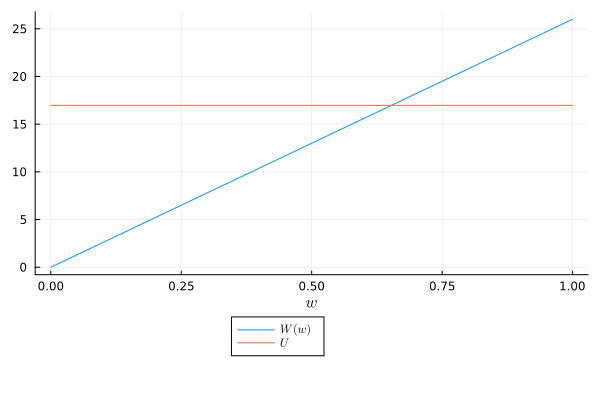

In [53]:
w_grid = collect(range(0,stop=1,length=101));
W_grid = ((1+r)/r)*w_grid;
U_grid = ((1+r)/r)*wr_analytical*ones(length(w_grid));

plot(w_grid,[W_grid,U_grid], label=[L"W(w)" L"U"], xlabel=L"w", legend=:outerbottom)

Given that we know what the correct solution is, let us now consider different numerical methods for solving the model instead.

### Numerically solving the reservation wage equation using numerical integration

Now consider an approach in which we use numerical (rather than analytical) methods to solve the reservation wage equation 

$$w_R=z+\frac{\alpha}{r}\int_{\underline{w_R}}^{\bar{w}}(w'-w_R)f(w')dw'$$

#### Note 1: Finding a "zero" of a function 

In general, the problem of solving an equation can be thought equivalently as a problem of "finding a zero" of a function. For example, solving the equation 

$$2x-1=5$$

is equivalent to finding a value of $x$ for which the function $g(x)=2x-6$ attains a value of zero. In practice, we often equations numerically by restating the problems into problems of finding zeros of functions, and using powerful algorithms for finding zeros of functions.

Here is how we can solve the above equation numerically:

In [8]:
g(x) = 2*x-6
find_zero(g,[-10,10])

3.0

Note that this uses the `find_zero()` function which takes as arguments the name of the function handle, followed by the limits of the region within which we are looking for solution.

In the context of the reservation wage equation, we can solve it numerically by "finding a zero" of the function 

$$FP(w_R)=w^R-z-\frac{\alpha}{r}\int_{\underline{w_R}}^{\bar{w}}(w'-w_R)f(w')dw'$$

#### Note 2: Numerical integration.

However, our equation involves integrals, so we need to use a correct numerical procedure for integrating (necessarily leading to an approximate solution). In Julia we can use the function `quadgk()[1]`, taking as arguments the integrand, the lower an the upper limit of integration. For example, to numerically integrate $g(x)=2x-6$ from 2 to 5 (i.e., to calculate $\int_1^3 (2x-6) dx$ we use 

In [9]:
g(x) = 2*x-6
quadgk(g,1,3)[1]

-4.0

In order to implement this in the context of the reservation wage equation note that 

$$FP(w_R)=w^R-z-\frac{\alpha}{r}\int_{\underline{w_R}}^{\bar{w}}(w'-w_R)f(w')dw'=w^R-z-\frac{\alpha}{r}\left[\int_{\underline{w_R}}^{\bar{w}}w'f(w')dw'- w_R\int_{\underline{w_R}}^{\bar{w}}f(w')dw'\right]$$

Then, using all of the above, we are ready to go, as follows

In [10]:
int_term1(w)=w*f(w);

FP1(wr)=wr-z-(alpha/r)*(quadgk(int_term1,wr,1)[1]-wr*quadgk(f,wr,1)[1]);

wr_numint1 = find_zero(FP1,(0,1))

0.6525931632714681

Note that in this case the numerical solution is exactly the same as the exact solution. 

### Solving reservation wage equation using direct numerical integration

While powerful, `quadgk()` function requires knowing the precise functional form. The standard way of dping numerical integration is to instead "discretize" the state space and then approximate the integral by a sum. For example, consider the previous problem of evaluating 

$$\int_1^3 (2x-6) dx$$  

Suppose that we approximate the interval $x\in[1,3]$ by the discrete grid of $n$ numbers $x\in\{x_1,x_2,...,x_n\}$ with $x_1=1$ and $x_n=3$ and let $\Delta x\equiv x_{n+1}-x_n$. Then we can think of the above integral as approximately equal to the sum 

$$\sum_{i=1}^n (2x_i-6)\Delta x$$

In fact, the value of the sum converges to the value of the integral when $\Delta x$ limits to zero (i.e. the discrete grid becomes infinitely "fine"). In the context of this example, we can approximate the integral as follows: 

In [11]:
# Construct a grid of 200 equally distant numbers between 1 and 3
xgrid = collect(range(1,stop=3,length=200));

# Find Delta x
dx = xgrid[2]-xgrid[1]

# Evaluate
sum(2*xgrid.-6)*dx

-4.020100502512581

#### A quick note: why .-

Note that `xgrid` is a 200x1 vector, so we can't add a scalar to it 

In [12]:
# The following returns an error - can't add scalar to vector

2*xgrid - 6

In [13]:
# This one adds the scalar to each element of the vector

2*xgrid .- 6

So `2*xgrid .- 6` is used to construct a vector in 6 is subtracted from each element of the vector `2*xgrid`

In the same way we can conduct numerical integration in the context of solving the reservation wage equation. Let as before

$$FP(w_R)=w^R-z-\frac{\alpha}{r}\int_{0}^{\bar{w}}\max\{0,w'-w_R\}f(w')dw'$$

To conduct numerical integration as above let's 

- discretize the state space of the wage offer grid $[0,1]$ by the vector $wgrid=\{0,0.01,0.02,...,1\}$ with $n=101$ elements
- with $\Delta w=0.01$

so that 

$$FP(w_R)=w^R-z-\frac{\alpha}{r}\sum_{i=1}^n\max\{0,w(i)-w_R\}Pr(w(i))\Delta w$$

In [14]:
# Now same but using direct numerical integration
w_grid = collect(range(0,stop=1,length=101))

dw = w_grid[2]-w_grid[1]

0.01

Note that since we now have probabilities, rather than probability densities, in the integrand, it is a good idea to adjust these probabilities so that they "integrate" to 1. Store the probabilities into a vector `fw` of the same length as the wage grid:

In [15]:
# adjust to integrate to 1
rat = sum(f(w_grid)*dw)
fw = f(w_grid)/rat;

Now note that

$$FP(w_R)=w^R-z-\frac{\alpha}{r}\sum_{i=1}^n\max\{0,w(i)-w_R\}Pr(w(i))\Delta w = w^R-z-\frac{\alpha}{r}\max\{0,wgrid-w_R\}'\times fw\times dw$$

where we use the fact that $\sum_i u_i v_i = u'v$ for column vectors $u$ and $v$.

Hence

In [16]:
FP2(wr)=wr-z-(alpha/r)*max.(w_grid.-wr,0)'*fw*dw;

wr_numint2 = find_zero(FP2,(0,1))

0.6549518569463549

Note that the solution is close to the analytical one, although not identical due to the numerical error. Nonetheless, doing the numerical integration directly allows us to solve much more general classes of problems than this one.

### Value function iterations

Perhaps the most powerful numerical method for solving systems of Bellman equations is the method of value function iterations. The goal here is to obtain numerical solutions for the whole vectors of discretized value functions. This method allows one to work with much more complicated models than the one considered here by only using the Bellman equations. It is probably the gold standard of computational methods.

#### Idea

The basic idea is as follows. Recall that the Bellman equations of the problem are

$$W(w)=w+\frac{1}{1+r}W(w)$$
$$U = z + \frac{1}{1+r}\left[(1-\alpha)U + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W(w'),U\}f(w')dw'\right]$$

- Suppose that I simply guess (potentially incorrectly) the functional form of the value functions. Let my guess for $W(w)$ is a function $W_0(w)$, and for $U$ is the scalar $U_0$. 
- Under my guess the right-hand sides of the Bellman equations are 

$$w+\frac{1}{1+r}W_0(w)$$
$$z + \frac{1}{1+r}\left[(1-\alpha)U_0 + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W_0(w'),U_0\}f(w')dw'\right]$$

- If (unlikely) I have guessed correctly, then when I evaluate these expressions, it will turn out that the first one evaluates to $W_0(w)$ and the second one to $U_0$, i.e. 

$$w+\frac{1}{1+r}W_0(w)=W_0(w)$$
$$z + \frac{1}{1+r}\left[(1-\alpha)U_0 + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W_0(w'),U_0\}f(w')dw'\right]=U_0$$

- Of course, unless I know the solution (in which case solving numerically would be unnecessary) it is very unlikely that my guess was correct, and therefore the right-hand sides would evaluate to different functions than the ones guessed.

However, consider the following procedure (algorithm).

1. Guess the value functions and let again my initial guesses be $W_0(w)$ and $U_0$.

2. Now plug the guessed functions into the RHSs of the Bellman equations and evaluate. Denote the resulting values as $W_1(w)$ and $U_1$ so that

$$W_1(w)=w+\frac{1}{1+r}W_0(w)$$
$$U_1=z + \frac{1}{1+r}\left[(1-\alpha)U_0 + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W_0(w'),U_0\}f(w')dw'\right]$$

3. Check if $W_1(w)=W_0(w)$ and $U_1=U_0$ (or at least if they are "sufficiently close"). 

- If so, then I guessed correctly. 
- If not, guess again, but now let my new guesses be $W_1(w)$ and $U_1$ obtained in step 2.



$$W_n(w)=w+\frac{1}{1+r}W_{n-1}(w)$$
$$U_n=z + \frac{1}{1+r}\left[(1-\alpha)U_{n-1} + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W_{n-1}(w'),U_{n-1}\}f(w')dw'\right]$$

- At each iteration, check if $W_n(w)=W_{n-1}(w)$ and $U_n=U_{n-1}$ (or are "sufficiently close")

5. **Surprise:** Under fairly general conditions, for discrete time Bellman equations on discretised state space, it is guaranteed that the procedure will converge to the true value under a finite number of iterations. This is formally the result of the Banach contraction mapping theorem.

#### Implementation

1. Set the parameters for the model.

2. The essential setup for implementing the procedure numerically is that we should use discretized versions of the Bellman equations. The idea is that we should approximate the continuous state space of the model (the support of the wage-offer distribution) by a vector of a finite number of values. 

- In our case the state space is the continuous interval $w\in[0,1]$. Approximate this by the vector 

$$wgrid = \begin{bmatrix}w_1\\w_2\\w_3\\ \vdots \\w_{n-1}\\w_n\end{bmatrix}$$

For example, with a vector of $n=101$ elements from 0 to 1

$$wgrid = \begin{bmatrix}w_1\\w_2\\w_3\\ \vdots \\w_{n-1}\\w_n\end{bmatrix} =\begin{bmatrix}0\\0.01\\0.02\\ \vdots \\0.99\\1\end{bmatrix}$$


- As a result, approximate all exogenous functions of $w$ by vectors of the same dimension as `wgrid`. In our case, let the pdf $f(w)$ be discretized as the vector

$$fw = \begin{bmatrix}f(w_1)\\f(w_2)\\f(w_3)\\ \vdots \\f(w_{n-1})\\f(w_n)\end{bmatrix}$$

- Similarly, approximate the (endogenous) value function $W(w)$ by the (unknown) vector 

$$W = \begin{bmatrix}W(w_1)\\W(w_2)\\W(w_3)\\ \vdots \\W(w_{n-1})\\W(w_n)\end{bmatrix}$$

and let $U$ be again a scalar.

- Hence, the Bellman equations 

$$W(w)=w+\frac{1}{1+r}W(w)$$
$$U = z + \frac{1}{1+r}\left[(1-\alpha)U + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W(w'),U\}f(w')dw'\right]$$

are discretized as

$$W=wgrid+\frac{1}{1+r}W$$
$$U = z + \frac{1}{1+r}\left[(1-\alpha)U + \alpha\times \max\{W,U\}'\times fw\times dw\right]$$

noting that $\max\{W,U\}'\times fw $ is a scalar.

3. Tolerance: Choose a sufficiently small level of tolerance under which you will be happy to conclude that the value functions from successive iterations are sufficiently small. In the code below we will impose that convergence occurs when pointwise differences between the elements of $W$ and $U$ from two successive iterations are at most 0.00001.

#### Code

In [47]:
#1. Set parameters and functional forms
r=0.04;
alpha=0.3;
z=0.2;
wmin=0;
wmax=1;
f(w)=pdf.(Uniform(wmin,wmax),w)

f (generic function with 1 method)

In [48]:
#2. Create a discrete wage grid
w_grid = collect(range(0,stop=1,length=101))
dw = w_grid[2]-w_grid[1];

# and a corresponding vector fw of probabilities so that the pdf integrates to 1
rat = sum(f(w_grid)*dw)
fw = f(w_grid)/rat;

In [49]:
# Guess (a potentially incorrect) discretized value function. Note that in this case we know the form of W so we might as well guess it correctly. 
# Soon we'll see this is not necessary

W0 = ((1+r)/r)*(w_grid)
U0 = 0.5

0.5

In [50]:
# Iterate to convergence
for i in 1:1000
    W1 = w_grid + (1/(1+r))*W0;
    U1 = z.+(1/(1+r))*((1-alpha)*U0.+alpha*max.(U0,W0)'*fw*dw);
    vals1 = [W1;U1]
    vals0 = [W0;U0]
    
    dist = abs(maximum(vals1-vals0))
    if dist <0.000001
        println("Convergence in $i iteration. Distance is $dist.")
        break
    else
        U0=U1;
        W0=W1;
    end
end

Convergence in 96 iteration. Distance is 9.126496038902587e-7.


As we can see the procedure converges after 96 iterations and the distance between the subsequent guesses is quite small.

We are done, but let's see what we find:

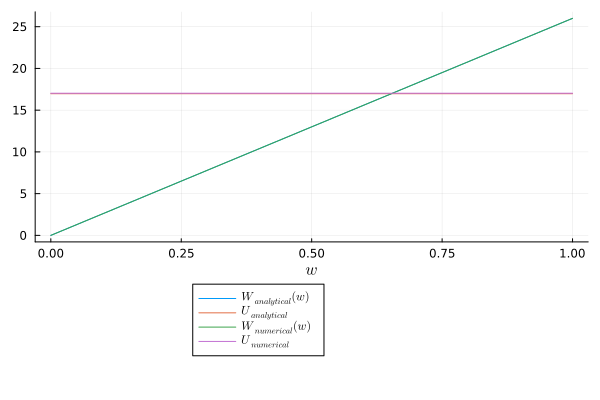

In [54]:
plot(w_grid,[W_grid,U_grid,W0,U0*ones(length(w_grid))], label=[L"W_{analytical}(w)" L"U_{analytical}" L"W_{numerical}(w)" L"U_{numerical}"], xlabel=L"w", legend=:outerbottom)

As we can see, the numerical solutions align closely with the analytical. 

Now to find the reservation wage from the numerical solution, find the first element of $W0$ that exceeds $U0$ and its corresponding value in the wage grid.

In [55]:
wr_ind = findfirst(x->x>=U0,W0)
wr = w_grid[wr_ind]

0.66

As we can see this is not so bad.

Now suppose that we had guessed even more incorrectly (also make incorrect guess for $W(w)$). Suppose we guessed that $W(w)=w$.

In [56]:
# Consider a wrong guess

W0 = w_grid
U0 = 0.5

for i in 1:1000
    W1 = w_grid + (1/(1+r))*W0;
    U1 = z.+(1/(1+r))*((1-alpha)*U0.+alpha*max.(U0,W0)'*fw*dw);
    vals1 = [W1;U1]
    vals0 = [W0;U0]
    
    dist = abs(maximum(vals1-vals0))
    if dist <0.000001
        println("Convergence in $i iteration. Distance is $dist.")
        break
    else
        U0=U1;
        W0=W1;
    end
end

Convergence in 353 iteration. Distance is 9.710268251694743e-7.


In [57]:
wr_ind = findfirst(x->x>=U0,W0)
wr = w_grid[wr_ind]

0.66

Procedure still works! In fact, for well-defined discrete time Bellman equations this method is extremely robust.

As a reminder, here is the complete code for the procedure:

In [64]:
#1. Set parameters and functional forms
r=0.04;
alpha=0.3;
z=0.2;
wmin=0;
wmax=1;
f(w)=pdf.(Uniform(wmin,wmax),w)

#2. Create a discrete wage grid
w_grid = collect(range(0,stop=1,length=101))
dw = w_grid[2]-w_grid[1];

# and a corresponding vector fw of probabilities so that the pdf integrates to 1
rat = sum(f(w_grid)*dw)
fw = f(w_grid)/rat;

# Guess incorrectly

W0 = w_grid
U0 = 0.5

# Iterate

for i in 1:1000
    W1 = w_grid + (1/(1+r))*W0;
    U1 = z.+(1/(1+r))*((1-alpha)*U0.+alpha*max.(U0,W0)'*fw*dw);
    vals1 = [W1;U1]
    vals0 = [W0;U0]
    
    dist = abs(maximum(vals1-vals0))
    if dist <0.000001
        println("Convergence in $i iteration. Distance is $dist.")
        break
    else
        U0=U1;
        W0=W1;
    end
end

Convergence in 353 iteration. Distance is 9.710268251694743e-7.


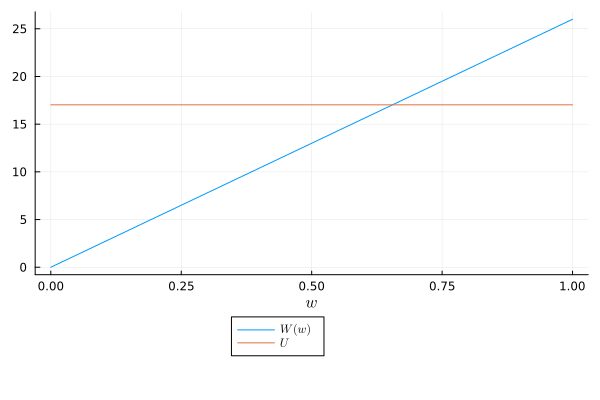

In [65]:
# Plot

plot(w_grid,[W0,U0*ones(length(w_grid))], label=[L"W(w)" L"U"], xlabel=L"w", legend=:outerbottom)

In [66]:
# Obtain reservation wage
wr_ind = findfirst(x->x>=U0,W0)
wr = w_grid[wr_ind]

0.66

### Different wage distribution

As a further example, suppose that the wage distribution is not uniform, but truncated normal with mean 0.5

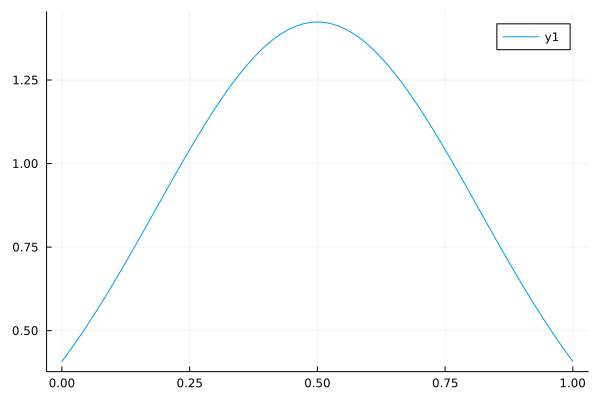

In [67]:
f(w)=pdf.(truncated(Normal(0.5, sqrt(0.1)),0,1),w);
plot(w_grid,f(w_grid))

Then the solution is (exactly the same code except for change of distribution)

In [68]:
#1. Set parameters and functional forms
r=0.04;
alpha=0.3;
z=0.2;
wmin=0;
wmax=1;
f(w)=pdf.(truncated(Normal(0.5, sqrt(0.1)),0,1),w);

#2. Create a discrete wage grid
w_grid = collect(range(0,stop=1,length=101))
dw = w_grid[2]-w_grid[1];

# and a corresponding vector fw of probabilities so that the pdf integrates to 1
rat = sum(f(w_grid)*dw)
fw = f(w_grid)/rat;

# Guess incorrectly

W0 = w_grid
U0 = 0.5

# Iterate

for i in 1:1000
    W1 = w_grid + (1/(1+r))*W0;
    U1 = z.+(1/(1+r))*((1-alpha)*U0.+alpha*max.(U0,W0)'*fw*dw);
    vals1 = [W1;U1]
    vals0 = [W0;U0]
    
    dist = abs(maximum(vals1-vals0))
    if dist <0.000001
        println("Convergence in $i iteration. Distance is $dist.")
        break
    else
        U0=U1;
        W0=W1;
    end
end

Convergence in 353 iteration. Distance is 9.710268251694743e-7.


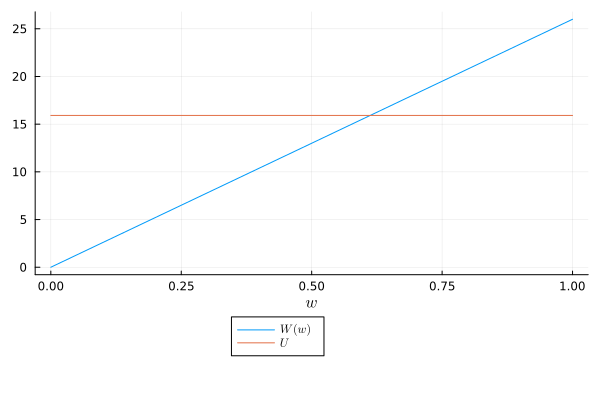

In [69]:
# Plot

plot(w_grid,[W0,U0*ones(length(w_grid))], label=[L"W(w)" L"U"], xlabel=L"w", legend=:outerbottom)

In [70]:
# Obtain reservation wage
wr_ind = findfirst(x->x>=U0,W0)
wr = w_grid[wr_ind]

0.62

We can see that the reservation wage is now lower than with uniform distribution

# McCall model with separations (Lake model)

Now, consider the basic McCall model with in discrete time. 

The Bellman equations for the model are

$$W(w)=w+\frac{1}{1+r}((1-\lambda)W(w)+\lambda U)$$
$$U = z + \frac{1}{1+r}\left[(1-\alpha)U + \alpha\int_{\underline{w}}^{\bar{w}}\max\{W(w'),U\}f(w')dw'\right]$$

Recall that optimal behaviour is fully characterized by a unique reservation wage, $w_R$, defined implicitly as the solution to 

$$w_R=z+\frac{\alpha}{r+\lambda}\int_{\underline{w_R}}^{\bar{w}}(w'-w_R)f(w')dw'$$

In these examples, let's set the parameters to $r=0.04$, $\alpha = 0.3$, $z=0.2$.

Let's solve this model. The following codes are very similar to above (only changing the corresponding equations) so we go over them without much explanation.

In [75]:
# Set parameters
r=0.04;
alpha=0.3;
lambda=0.05;
z=0.2;

Let's again start with a uniform distribution for which we have an exact solution. In similar way to before we can obtain the reservation wage in closed form and it is
    
$$w_r = \frac{r+\lambda+\alpha-\sqrt{(r+\lambda+\alpha)^2 - \alpha(2z(r+\lambda)+\alpha)}}{\alpha}$$

In [76]:
# Wage offer distribution
wmin=0;
wmax=1;
f(w)=pdf.(Uniform(wmin,wmax),w)

f (generic function with 1 method)

In [77]:
# Analytical solution

wr_analytical = ((r+lambda+alpha)-sqrt((r+lambda+alpha)^2 - alpha*(2*z*(r+lambda)+alpha)))/alpha

0.5450165564729249

### Numerical solutions via numerical integration in the reservation wage equation

In [79]:
int_term1(w)=w*f(w);

FP1(wr)=wr-z-(alpha/(r+lambda))*(quadgk(int_term1,wr,1)[1]-wr*quadgk(f,wr,1)[1]);

wr_numint1 = find_zero(FP1,(0,1))

0.545016556472925

In [82]:
# Now same but using direct numerical integration
w_grid = collect(range(0,stop=1,length=101))
dw = w_grid[2]-w_grid[1]

# adjust to integrate to 1
rat = sum(f(w_grid)*dw)
fw = f(w_grid)/rat;

In [83]:
FP2(wr)=wr-z-(alpha/(r+lambda))*max.(w_grid.-wr,0)'*fw*dw;

wr_numint2 = find_zero(FP2,(0,1))

0.5466579292267366

### Value function iterations

Same as before but the discretized Bellman equations are now

$$W=wgrid+\frac{1}{1+r}((1-\lambda)W .+ \lambda U)$$
$$U = z + \frac{1}{1+r}\left[(1-\alpha)U + \alpha\times \max\{W,U\}'\times fw\times dw\right]$$

In [86]:
# Incorrect guesses
W0 = ((1+r)/r)*w_grid
U0 = 0.2

# Iterations
for i in 1:1000
    W1 = w_grid + (1/(1+r))*(lambda*U0 .+ (1-lambda)*W0);
    U1 = z + (1/(1+r))*((1-alpha)*U0 + alpha*max.(W0,U0)'*fw*dw)
    vals1 = [W1;U1]
    vals0 = [W0;U0]
    if norm(vals1-vals0)<0.000001
        dis = abs(minimum(vals1-vals0));
        println("Convergence in $i iterations. Distance is $dis")
        break
    else
        W0=W1;
        U0=U1;
    end
end

Convergence in 321 iterations. Distance is 9.804016798398152e-8


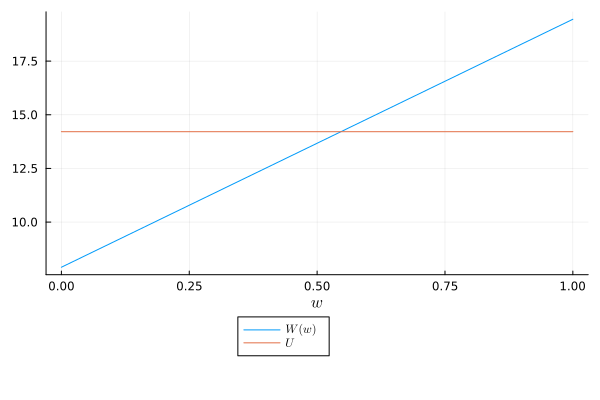

In [87]:
# Plot

plot(w_grid,[W0,U0*ones(length(w_grid))], label=[L"W(w)" L"U"], xlabel=L"w", legend=:outerbottom)

In [88]:
wr_ind = findfirst(x->x>=U0,W0)
wr = w_grid[wr_ind]

0.55

### Truncated normal distribution

In [89]:
#1. Set parameters and functional forms
r=0.04;
alpha=0.3;
z=0.2;
wmin=0;
wmax=1;
f(w)=pdf.(truncated(Normal(0.5, sqrt(0.1)),0,1),w);

#2. Create a discrete wage grid
w_grid = collect(range(0,stop=1,length=101))
dw = w_grid[2]-w_grid[1];

# and a corresponding vector fw of probabilities so that the pdf integrates to 1
rat = sum(f(w_grid)*dw)
fw = f(w_grid)/rat;

# Guess incorrectly

W0 = ((1+r)/r)*w_grid
U0 = 0.2

# Iterations
for i in 1:1000
    W1 = w_grid + (1/(1+r))*(lambda*U0 .+ (1-lambda)*W0);
    U1 = z + (1/(1+r))*((1-alpha)*U0 + alpha*max.(W0,U0)'*fw*dw)
    vals1 = [W1;U1]
    vals0 = [W0;U0]
    if norm(vals1-vals0)<0.000001
        dis = abs(minimum(vals1-vals0));
        println("Convergence in $i iterations. Distance is $dis")
        break
    else
        W0=W1;
        U0=U1;
    end
end

Convergence in 318 iterations. Distance is 9.808460177396228e-8


In [90]:
wr_ind = findfirst(x->x>=U0,W0)
wr = w_grid[wr_ind]

0.52

As you can see, using these methods, you can solve easily broad classes of McCall-type models (as well as many other models).